<a href="https://colab.research.google.com/github/kollerbud/btc_project/blob/main/notebooks/Project6242.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!python --version

Python 3.10.12


In [ ]:
# df_combine = pd.merge(df, df_fred, left_on='Date_time', right_on='DATE', how='inner').reset_index(drop=True).set_index('Date_time')

# Exploratory Data Analysis

In [ ]:
from typing import Any, Tuple, Dict, List
import numpy as np
import seaborn as sns
import statsmodels.api as stat
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
def clean_na(df: pd.DataFrame,
             target_var_list: list) -> pd.DataFrame:
  # fill NAs in dataframe
  df_copy = df.copy()
  # remove target column(s)
  if isinstance(target_var_list, list):
    df_copy = df_copy.loc[:, ~df_copy.columns.isin(target_var_list)]
  else:
    raise TypeError('use format "[column_name]"')
  # find column of "object" datatype
  obj_col = df_copy.select_dtypes(include=['object']).columns
  for col in obj_col:
    try:
      df_copy[col] = df_copy[col].astype(float)
    except TypeError:
      df_copy[col] = df_copy[col].replace({'null':np.nan})
      df_copy[col] = df_copy[col].astype(float)
    except ValueError:
      df_copy[col] = df_copy[col].replace({'null':np.nan})
      df_copy[col] = df_copy[col].astype(float)

  # add target back in
  df_copy[target_var_list] = df[target_var_list]
  # fill NAs
  df_copy = df_copy.fillna(method='ffill')
  return df_copy

In [ ]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3576830/
# .30 to .50 (−.30 to −.50)	Low positive (negative) correlation
# .00 to .30 (.00 to −.30)	negligible correlation
# clean_df = clean_na(df_combine, target_var_list=['BTC_price'])
clean_df = clean_na(df, target_var_list=['BTC_price'])

corr_matrix = clean_df.corr().abs()

KeyError: ignored

In [ ]:
def remove_correlation(df: pd.DataFrame,
                       target_var_list: list,
                       include_col_list: list=None,
                       cut_off: int=0.7) -> pd.DataFrame:
  # https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on
  # https://www.kaggle.com/code/oldwine357/removing-highly-correlated-features
  df_copy = df.copy()
  # remove target column(s)
  if isinstance(target_var_list, list):
    df_copy = df_copy.loc[:, ~df_copy.columns.isin(target_var_list)]
  else:
    raise TypeError('use format "[column_name]"')
  # create correlation matrix
  corr_matrix = df_copy.corr().abs()
  # select upper triangle of the correlation matrix
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
  # find columns(features) with correlation higher than cut_off
  to_drop = [col for col in upper.columns if any(upper[col]>cut_off)]

  print(f'{len(to_drop)} columns dropped: {to_drop}')
  # drop the columns
  df_copy.drop(to_drop, axis=1, inplace=True)
  # add excluded list back in
  if include_col_list is not None:
    df_copy[include_col_list] = df[include_col_list]
  # add target back in
  df_copy[target_var_list] = df[target_var_list]

  return df_copy

In [ ]:
df_uncorr = remove_correlation(clean_df,
                               target_var_list=['BTC_price'],
                               cut_off=0.5)

<ipython-input-10-e3225daf9a2e>:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_copy.corr().abs()


506 columns dropped: ['CPI_yoy', 'Import_constant_USD', 'Prod_constant_USD', 'Months_cover_foreign_reserved', 'real_exchange_rate', 'retail_sales_vol_index', 'Terms_of_trade', 'total_reserves', 'unemployment_rate', 'sp500', 'acwi', 'btc_total_size', 'btc_total_weight', 'btc_total_transactions', 'btc_total_transaction_value', 'CNY_exchange_rate', 'EUR_exchange_rate', 'JPY_exchange_rate', 'gold_price', 'sse_index_price', 'sse_index_vol', 'vix_price', 'crude_oil_price', 'crude_oil_vol', 'BTC_vol', 'D_AB1020AAVOL', 'D_AB14AAAMT', 'D_AB14AAVOL', 'D_AB2140AAVOL', 'D_AB4180AAVOL', 'D_AB59AAVOL', 'D_ABGT80AAVOL', 'D_DEXBZUS', 'D_DEXCAUS', 'D_DEXCHUS', 'D_DEXDNUS', 'D_DEXHKUS', 'D_DEXINUS', 'D_DEXJPUS', 'D_DEXKOUS', 'D_DEXMAUS', 'D_DEXMXUS', 'D_DEXNOUS', 'D_DEXSDUS', 'D_DEXSFUS', 'D_DEXSIUS', 'D_DEXSLUS', 'D_DEXSZUS', 'D_DEXTAUS', 'D_DEXTHUS', 'D_DEXUSAL', 'D_DEXUSEU', 'D_DEXUSNZ', 'D_DEXUSUK', 'D_DEXVZUS', 'D_DTWEXAFEGS', 'D_DTWEXBGS', 'D_DTWEXEMEGS', 'D_FIN1020AAVOL', 'D_FIN14AAVOL', 'D_FIN21

In [ ]:
_scaler = MinMaxScaler | StandardScaler
def normalize_data(df: pd.DataFrame,
                   scaler: _scaler=MinMaxScaler()) -> Tuple[str, dict]:
  df_copy = df.copy()
  # exclude dates
  use_cols = df_copy.select_dtypes(exclude=['datetime']).columns
  df_copy = df_copy.loc[:, use_cols]

  scaler_dict = {}
  for col in df_copy.columns:
    # loop through all columns and normalize data
    # reshape each column
    to_scale = np.array(df_copy[col]).reshape(-1,1)

    scaler_dict[col+'_scaler'] = scaler
    df_copy[col]=scaler.fit_transform(to_scale)
  return {'df': df_copy,
          'scaler_obj':scaler_dict
          }

In [ ]:
df_uncorr['crypto_trend'] = clean_df['crypto_trend']
df_norm = normalize_data(df_uncorr, scaler=StandardScaler())

In [ ]:
def data_splits(df: pd.DataFrame,
                target_var_list: list,
                train_perc: float=0.75,
                valid_perc: float=0.10,
                test_perc: float=0.15,
                )-> Dict[str, List[pd.DataFrame]]:

  df_copy = df.copy()

  _x = df_copy.loc[:, ~df_copy.columns.isin(target_var_list)]
  _y = df_copy.loc[:, target_var_list]
  # train is now 75% of the entire data set
  x_train, x_test, y_train, y_test = train_test_split(_x, _y, test_size=1 - train_perc, shuffle=False)
  # test is now 10% of the initial data set
  # validation is now 15% of the initial data set
  x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_perc/(test_perc + valid_perc), shuffle=False)


  return {'train_set': [x_train, y_train],
          'valid_set': [x_val, y_val],
          'test_set': [x_test, y_test],
          }

In [ ]:
def feature_selection_by_p(df: pd.DataFrame,
                           target_var_list: list,
                           p_val: float=0.05,
                          ):
  'select features by p-value'
  # initialize dataframe
  df_copy = df.copy()
  # exlcude columns
  if not isinstance(target_var_list, list):
    raise TypeError('use format "[column_name]"')

  _target = df_copy.loc[:, target_var_list]
  _feature = df_copy.loc[:, ~df_copy.columns.isin(target_var_list)]

  # https://stackoverflow.com/questions/41075098/how-to-get-the-p-value-in-a-variable-from-olsresults-in-python
  ols_model = stat.OLS(_target, stat.add_constant(_feature)).fit()


  return ols_model

# EDA Pipeline

In [ ]:
def EDA_Pipeline(df: pd.DataFrame,
                 target_col: list):

  # initialize dataframe
  df_copy = df.copy()

  # data type clean up and fill na
  df_clean = clean_na(df=df_copy, target_var_list=target_col)

  # remove correlated columns
  df_decorr = remove_correlation(df=df_clean,
                                 target_var_list=target_col,
                                 include_col_list=['crypto_trend'],
                                 cut_off=0.5)

  # normalize data
  norm = normalize_data(df=df_decorr, scaler=StandardScaler())

  df_norm = norm['df']
  scalers = norm['scaler_obj']

  # split data
  split_data = data_splits(df=df_norm, target_var_list=target_col)

  return {'splitted_data': split_data,
          'scaler_obj': scalers,
          }

In [ ]:
after_eda = EDA_Pipeline(df=df_combine, target_col=['BTC_price'])

<ipython-input-10-e3225daf9a2e>:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_copy.corr().abs()


506 columns dropped: ['CPI_yoy', 'Import_constant_USD', 'Prod_constant_USD', 'Months_cover_foreign_reserved', 'real_exchange_rate', 'retail_sales_vol_index', 'Terms_of_trade', 'total_reserves', 'unemployment_rate', 'sp500', 'acwi', 'btc_total_size', 'btc_total_weight', 'btc_total_transactions', 'btc_total_transaction_value', 'CNY_exchange_rate', 'EUR_exchange_rate', 'JPY_exchange_rate', 'gold_price', 'sse_index_price', 'sse_index_vol', 'vix_price', 'crude_oil_price', 'crude_oil_vol', 'BTC_vol', 'D_AB1020AAVOL', 'D_AB14AAAMT', 'D_AB14AAVOL', 'D_AB2140AAVOL', 'D_AB4180AAVOL', 'D_AB59AAVOL', 'D_ABGT80AAVOL', 'D_DEXBZUS', 'D_DEXCAUS', 'D_DEXCHUS', 'D_DEXDNUS', 'D_DEXHKUS', 'D_DEXINUS', 'D_DEXJPUS', 'D_DEXKOUS', 'D_DEXMAUS', 'D_DEXMXUS', 'D_DEXNOUS', 'D_DEXSDUS', 'D_DEXSFUS', 'D_DEXSIUS', 'D_DEXSLUS', 'D_DEXSZUS', 'D_DEXTAUS', 'D_DEXTHUS', 'D_DEXUSAL', 'D_DEXUSEU', 'D_DEXUSNZ', 'D_DEXUSUK', 'D_DEXVZUS', 'D_DTWEXAFEGS', 'D_DTWEXBGS', 'D_DTWEXEMEGS', 'D_FIN1020AAVOL', 'D_FIN14AAVOL', 'D_FIN21

# Random Forest


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
import seaborn as sns

In [ ]:
# https://florianwilhelm.info/2020/05/honey_i_shrunk_the_target_variable/
# https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html#sphx-glr-auto-examples-compose-plot-transformed-target-py

_x_train = after_eda['splitted_data']['train_set'][0]
_y_train = after_eda['splitted_data']['train_set'][1]

inv_y_train = after_eda['scaler_obj']['BTC_price_scaler'].inverse_transform(_y_train.values.reshape(-1,1))
log_y = np.log1p(inv_y_train)

<ipython-input-39-b6205e0e2e2a>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(inv_y_train, fit=norm)


Text(0.5, 1.0, 'BTC Price Distribution')

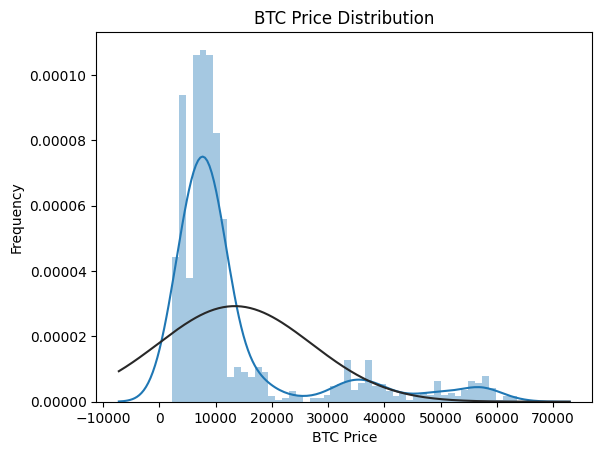

In [ ]:
sns.distplot(inv_y_train, fit=norm)
mu, sigma = norm.fit(inv_y_train)
plt.ylabel('Frequency')
plt.xlabel('BTC Price')
plt.title('BTC Price Distribution')

<ipython-input-40-f1b95f16b5be>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(log_y, fit=norm)


Text(0.5, 0, 'Log BTC Price')

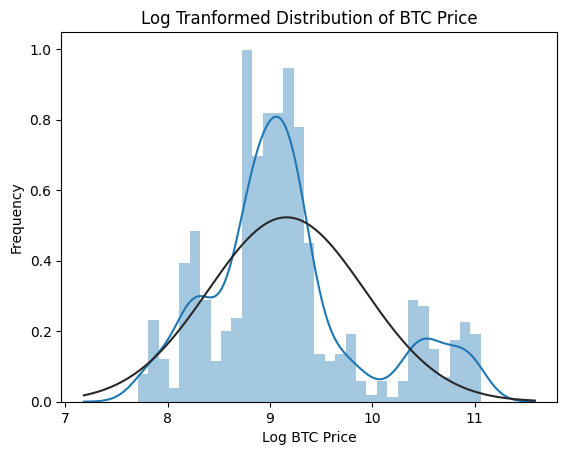

In [ ]:
sns.distplot(log_y, fit=norm)
log_mu, log_sigma = norm.fit(log_y)
plt.title('Log Tranformed Distribution of BTC Price')
plt.ylabel('Frequency')
plt.xlabel('Log BTC Price')

In [ ]:
rf = RandomForestRegressor(#n_estimators=int(np.sqrt(len(_x_train))),
                            random_state=123,
                           )
rf.fit(X=_x_train, y=log_y)

_x_valid = after_eda['splitted_data']['valid_set'][0]

pred = rf.predict(_x_valid)
# inv_pred = np.expm1(pred)

actual = after_eda['splitted_data']['valid_set'][1]
inv_actual = after_eda['scaler_obj']['BTC_price_scaler'].inverse_transform(actual.values.reshape(-1,1))
log_actual = np.log1p(inv_actual)

root_score = np.sqrt(metrics.mean_squared_error(pred, log_actual))

print(f'RMSE {root_score}')

<ipython-input-20-da4d3f2e9771>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X=_x_train, y=log_y)


RMSE 0.19921065733698656


In [ ]:
importances = list(zip(rf.feature_importances_, _x_train.columns))
importances.sort(reverse=True)
print(importances)

[(0.8493822949720221, 'CPI_adj'), (0.09459266567455961, 'crypto_trend'), (0.02412503219556831, 'Export_constant_USD'), (0.006866024789594147, 'M_CEU0500000002'), (0.00422768298480837, 'D_ABGT80AAAMT'), (0.002027610920770404, 'D_FIN14AAAMT'), (0.002016193580552051, 'gold_trade_vol'), (0.0019649760975716394, 'M_MARTSMPCSM44X72USN'), (0.001454117812327483, 'D_NONFIN2140AAAMT'), (0.0014103344009826055, 'D_AB4180AAAMT'), (0.0012288308159601265, 'D_NONFINGT80A2P2AMT'), (0.001178030751359374, 'D_NONFIN14AAAMT'), (0.0011044472921569787, 'D_NONFIN4180AAAMT'), (0.0009978569529345027, 'D_NONFIN4180A2P2AMT'), (0.0009385418396278712, 'D_NONFIN1020AAAMT'), (0.0008615254975457386, 'D_FIN59AAAMT'), (0.0008158823537140714, 'D_FIN2140AAAMT'), (0.0008021092669960745, 'D_FINGT80AAAMT'), (0.0007035701172950784, 'D_FIN4180AAAMT'), (0.0006565398625605316, 'D_AB1020AAAMT'), (0.0006399583451366248, 'D_AB59AAAMT'), (0.0005526638581027321, 'D_NONFINGT80AAAMT'), (0.0005309043174347099, 'D_NONFIN59AAAMT'), (0.0004

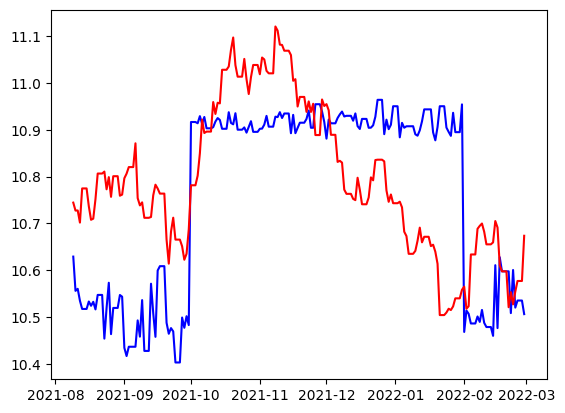

In [ ]:
x_values = after_eda['splitted_data']['valid_set'][0].index
plt.plot(x_values, pred, label='pred', color='blue')
plt.plot(x_values, log_actual, label='actual', color='red')
plt.show()

# Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lr = LinearRegression()
lr.fit(X=_x_train, y=log_y)

lr_pred = lr.predict(_x_valid)

root_score = np.sqrt(metrics.mean_squared_error(lr_pred, log_actual))

print(f'RMSE {root_score}')

RMSE 0.3957836986777578


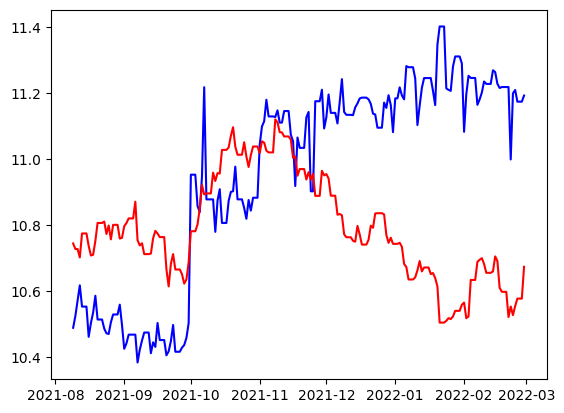

In [ ]:
x_values = after_eda['splitted_data']['valid_set'][0].index
plt.plot(x_values, lr_pred, label='pred', color='blue')
plt.plot(x_values, log_actual, label='actual', color='red')
plt.show()

# XGBOOST

In [ ]:
from xgboost import XGBRegressor

In [ ]:
xgb = XGBRegressor()

xgb.fit(X=_x_train, y=log_y)

xgb_pred = xgb.predict(_x_valid)

root_score = np.sqrt(metrics.mean_squared_error(xgb_pred, log_actual))

print(f'RMSE {root_score}')

RMSE 0.19539003903313984


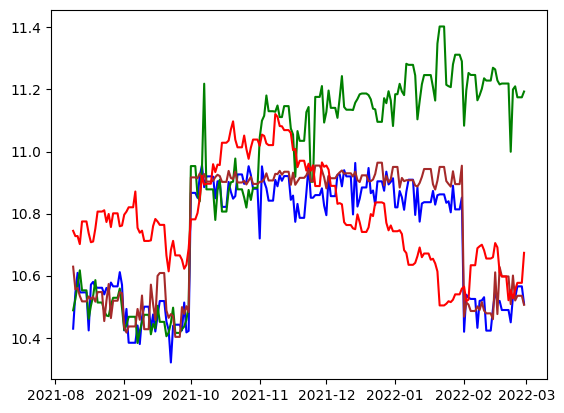

In [ ]:
x_values = after_eda['splitted_data']['valid_set'][0].index
plt.plot(x_values, xgb_pred, label='pred', color='blue')
plt.plot(x_values, lr_pred, label='pred', color='green')


plt.plot(x_values, log_actual, label='actual', color='red')
plt.show()